In [1]:
# Setup the environment for google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install ipympl jiminy_py[meshcat] av > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/robot.urdf -O robot.urdf > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/robot_hardware.toml -O robot_hardware.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/robot_options.toml -O robot_options.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/part_1.toml -O part_1.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/part_2.toml -O part_2.toml > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/simple_pendulum/part_3.toml -O part_3.toml > /dev/null 2>&1
except ImportError:
    pass

In [1]:
# Enable matplotlib interactive notebook integration
%matplotlib widget

In [2]:
# Generic import that will be useful throughout this notebook
import numpy as np

# The main module of jiminy
import jiminy_py.core as jiminy
from jiminy_py.simulator import Simulator

# Import low-level Rigid-Body Dynamics library
import pinocchio as pin

In [3]:
# Instantiate the simulator
simulator = Simulator.build(urdf_path="robot.urdf", has_freeflyer=False)
robot = simulator.robot

# Import "part_<X>.toml") to load exercice <X> by increasing difficulty up to 3, then comment out import
simulator.import_options("part_3.toml")

In [5]:
# Get the list of available sensors
for sensor_type, sensors in robot.sensors.items():
    print(f"* {sensor_type}:")
    for sensor in sensors:
        print(f"  * {sensor.name}")

* EffortSensor:
  * PendulumJoint
* ImuSensor:
  * PendulumMass
* EncoderSensor:
  * PendulumJoint


In [6]:
# Define gravity and get mass of the pole
gravity = 9.81
mass = robot.pinocchio_data.mass[0]
length = robot.pinocchio_data.oMf[-2].translation[-1]

In [7]:
angle_desired = 0.0

# Define the command: for now, the motor outputs zero torque.
def compute_command(t, q, v, sensors_data, command):
    global angle_desired
    q_mot, v_mot = sensors_data['EncoderSensor', 'PendulumJoint']
    k_flex, k_control = 500.0, 100.0
    k_mean = 1.0 / (1.0 / k_flex + 1.0 / k_control)
    q_flex = 0.0
    for _ in range(2):
      q_target = angle_desired - gravity * length * mass * np.sin(q_mot + q_flex) / k_mean
      q_flex = (k_control / k_flex) * (q_mot - q_target)
    command[:] = - k_control * ((q_mot - q_target) + 0.3 * v_mot)

# Instantiate the controller and attach it to the robot
simulator.stop()
robot.controller = jiminy.FunctionalController(compute_command)

In [8]:
for _ in range(10):
    # Set initial condition and target pole angle
    q_init = pin.neutral(robot.pinocchio_model_th)
    v_init = np.random.rand(robot.pinocchio_model_th.nv)

    # Launch the simulation
    angle_desired = np.pi * np.random.rand()
    simulator.simulate(t_end=3.0, q_init=q_init, v_init=v_init, is_state_theoretical=True)

    # Check it the desired pole angle has been reached within acceptable margins
    print("Desired pole angle:", angle_desired)
    gyro_data, accel_data = np.split(robot.controller.sensor_measurements['ImuSensor', 'PendulumMass'].copy(), 2)
    assert np.allclose(gyro_data, 0.0, atol=1e-3), "Pole has not reached equilibrium"
    angle = np.arctan2(*accel_data[1:])
    error_angle = min(np.abs(angle - angle_desired), 2.0 * np.pi - np.abs(angle - angle_desired))
    print("Error pole angle:", error_angle)
    assert error_angle < 1e-3, f"Error is too large: measured={angle:.3f}, target={angle_desired:.3f}"

  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 0.15477558868360708
Error pole angle: 8.538222732723533e-06


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 1.2711499081109359
Error pole angle: 3.0360014133812285e-06


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 1.078105269505019
Error pole angle: 8.30164763265806e-06


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 1.7271888669742463
Error pole angle: 3.412461457652505e-05


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 0.9617971499024289
Error pole angle: 1.3822720694056656e-05


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 2.503288637054338
Error pole angle: 2.9636568878999014e-05


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 0.7084460475823015
Error pole angle: 1.9839710672320265e-05


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 0.10816967789768928
Error pole angle: 6.611548251503341e-06


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 2.6968788595566
Error pole angle: 2.6205543334434367e-05


  0%|          | 0.00/3.0 [00:00<?]

Desired pole angle: 1.8323750302989328
Error pole angle: 4.1901851583148186e-05


In [9]:
# Replay the simulation
camera_pose = ([-5.0, 0.0, 0.0], [np.pi/2, 0.0, -np.pi/2])
simulator.replay(camera_pose=camera_pose, speed_ratio=1.0, record_video_size=(400, 400), backend="panda3d-sync")
simulator.close()

Rendering frames: 100%|██████████| 91/91 [00:00<00:00, 373.91it/s]


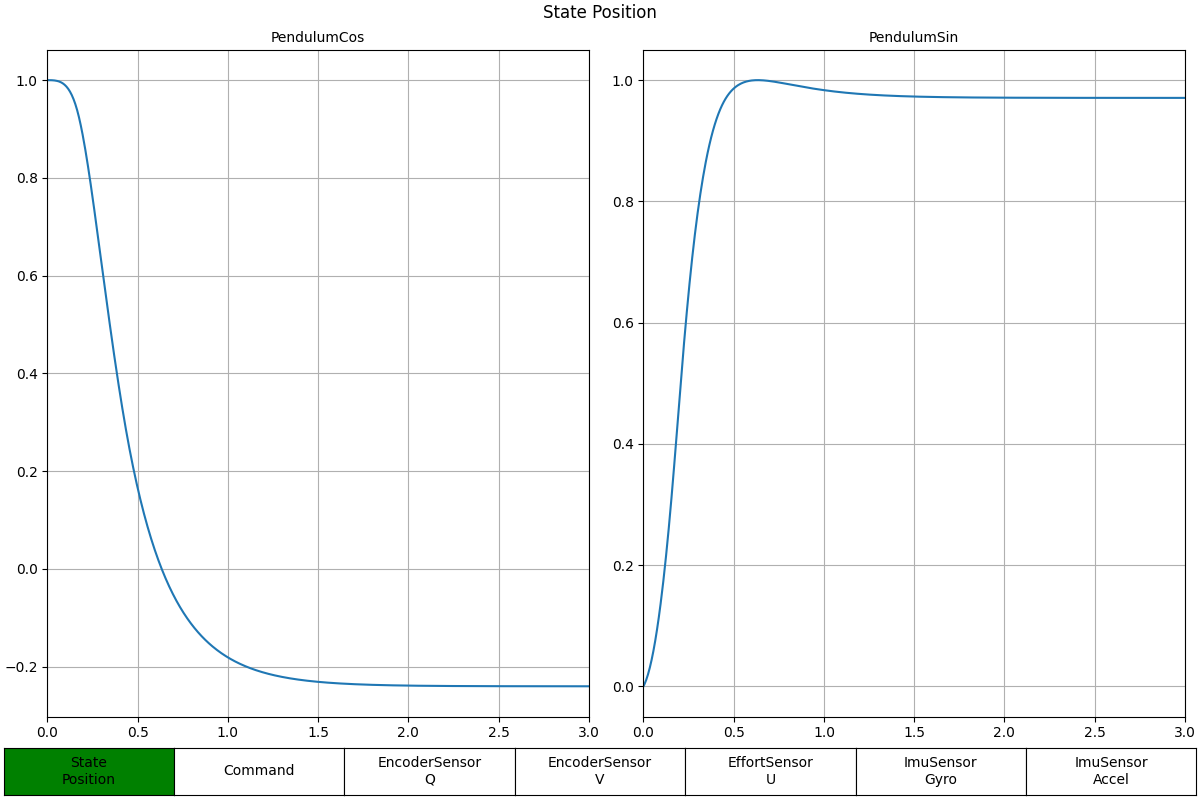

In [10]:
# Plot some metrics
fig_tabbed = simulator.plot()
fig_tabbed.remove_tab('State Position')